In [1]:
# General
import os, sys, pickle, json
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

In [2]:
# Import classifier
with open(os.getcwd() + '/data/clf.pickle', 'rb') as f:
    clf = pickle.load(f)
# Import NN
with open(os.getcwd() + '/data/nn.pickle', 'rb') as f:
    nn = pickle.load(f)

# load case base data
X_base = pd.read_csv(os.getcwd() + '/data/X_base.csv')
X_base_decoded = pd.read_csv(os.getcwd() + '/data/X_base_decoded.csv')
meta_base = pd.read_csv(os.getcwd() + '/data/meta_base.csv')
SHAP_base = pd.read_csv(os.getcwd() + '/data/SHAP_base.csv')
y_base = pd.read_csv(os.getcwd() + '/data/y_base.csv')

# load alert data
X_alert = pd.read_csv(os.getcwd() + '/data/X_alert.csv')
X_alert_decoded = pd.read_csv(os.getcwd() + '/data/X_alert_decoded.csv')
meta_alert = pd.read_csv(os.getcwd() + '/data/meta_alert.csv')
SHAP_alert = pd.read_csv(os.getcwd() + '/data/SHAP_alert.csv')
y_alert = pd.read_csv(os.getcwd() + '/data/y_alert.csv')

# load separate train data
X_train = pd.read_csv(os.getcwd() + '/data/X_train.csv')

# Simulated User Experiment
* **Case base**: the cases shown to the user.
* **Test set**: the alerts generated by the machine learning model.

##### Metrics
* Brier score: best callibration;
* AUC score: best prediction performance;

## SHAP-Weighted Experiment

### Schemes
* nFw: neighbors retrieved by feature values * alert_shap
    * - wUu : probabilities unweighted
    * - wFw : probabilities weighted by feature values * alert_shap; i.e. weight 
        instances with similar feature values on important features higher;
    * - wFu : probabilities weighted by feature values; i.e. weight instances with similar feature values higher
    * - wSu: probabilities weighted by shap values; i.e. weight instances with similar explanation higher
* nFu: neighbors retrieved by feature values alone
    * - wUu : probabilities unweighted
    * - wFw : probabilities weighted by feature values * alert_shap; i.e. weight 
        instances with similar feature values on important features higher;
    * - wFu : probabilities weighted by feature values; i.e. weight instances with similar feature values higher
    * - wSu: probabilities weighted by shap values; i.e. weight instances with similar explanation higher

In [121]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

def define_distance_function(contr):
    """
    Parameters
    ----------
    contr : array like
        shap values of instance
        
    Returns
    -------
    weighted_distance : function
        function that computes the distance weighted by feature contributions
    """
    contr = np.abs(np.array(contr))
    
    def weighted_distance(a, b):
        """ compute distance between a and b, weighted by feature contributions
        Parameters
        ---------
        a : array
        b : array
        
        Returns
        -------
        distance : float
            weighted distance between array a and b
        """
        distance = np.sum(np.square(np.array(a) * contr - np.array(b) * contr))
        return distance
    return weighted_distance

class SingleWeightedKNeighborsClassifier:
    """ Nearest neighbors classifier that evaluates on a per-instance basis which allows for instance-dependent 
    distance function.
    """
    
    def __init__(self, n_neighbors, metric_n='weighted_euclidean', metric_w='weighted_euclidean', weights='distance'):
        self.n_neighbors = n_neighbors
        self.metric_n = metric_n
        self.metric_w = metric_w
        self.weights = weights
        return
    
    def fit(self, X_train_n, X_train_w, y_train):
        """ Fakenews fit that doesn't actually fit anything. Just saves data.
        Parameters
        ----------
        X_train_n : array [n_samples, n_features]
            data used to retrieve the neighbors
        X_train_w : array [n_samples, n_features]
            data used to weight the retrieved neighbors
        y_train : array [n_samples]
            true class
        """
        self.X_train_n = X_train_n
        self.X_train_w = X_train_w
        self.y_train = y_train
        return
    
    def predict_proba(self, X_test_n, X_test_w, C_test = None):
        """ estimate accuracy of k-NN
        
        Parameters
        ----------
        X_test_n : array [n_samples, n_features]
            data used to retrieve the neighbors
        X_test_w : array [n_samples, n_features]
            data used to weight the retrieved neighbors
        C_test : array [n_samples, n_features]
            feature contributions for test instances; only used when metric_n or metric_w is equal to weighted_euclidean
            
        Returns
        -------
        y_prob : array [n_samples]
            probabilities
        """
        
        # find neighbors
        if self.metric_n == 'weighted_euclidean': # slow
            distances_neighbors = []
            neighbors = []
            for instance, index in zip(np.array(X_test_n), range(len(X_test_n))):
                distance_function_n = define_distance_function(C_test.iloc[index])
                nn = NearestNeighbors(n_neighbors = self.n_neighbors, algorithm = 'brute', metric = distance_function_n)
                nn.fit(self.X_train_n, self.y_train)
                distances_neighbors_i, neighbors_i = nn.kneighbors([instance])
                distances_neighbors.append(distances_neighbors_i[0])
                neighbors.append(neighbors_i[0])
        else: # fast
            nn = NearestNeighbors(n_neighbors = self.n_neighbors, algorithm = 'brute', metric = self.metric_n)
            nn.fit(self.X_train_n, self.y_train)
            distances_neighbors, neighbors = nn.kneighbors(X_test_n)
        
        # compute distance weighted probabilities
        y_prob = []
        
        if self.weights == 'distance':
            for n, instance, index in zip(neighbors, np.array(X_test_w), range(len(X_test_w))):
                # retrieve neighbors
                X_neighbors = self.X_train_w.iloc[n]
                # compute distances
                if self.metric_w == 'weighted_euclidean':
                    distances = []
                    distance_function_w = define_distance_function(C_test.iloc[index])
                    for neighbor in n:
                        distances.append(distance_function_w(neighbor, instance))
                    distances = np.array([10**-10 if i==0 else i for i in distances])
                if self.metric_w == 'euclidean':
                    distances = np.array([10**-10 if i == 0 else i for i in euclidean_distances(X_neighbors, [instance]).ravel()])
                # compute weighted score
                distances_weights = 1/distances
                true_class = y_train.iloc[n]['class'].ravel()
                p = np.sum(distances_weights*true_class)/np.sum(distances_weights)
                y_prob.append([1-p, p])
        elif self.weights == 'uniform':
            for n in zip(neighbors):
                true_class = y_train.iloc[n]['class'].ravel()
                # compute unweighted score
                p = np.mean(true_class)
                y_prob.append([1-p, p])
        return y_prob

In [122]:
def simulate_user(scheme, n_neighbors=10):
    """
    """
    # Set retrieve neighbors
    if scheme[1] == 'S':
        X_train_n = SHAP_base
        X_test_n = SHAP_alert
    elif scheme[1] == 'F':
        X_train_n = X_base
        X_test_n = X_alert
        
    # Set measure_n
    if scheme[2] == 'w':
        metric_n = 'weighted_euclidean'
    elif scheme[2] == 'u':
        metric_n = 'euclidean'
   
    # Set compute weights
    if scheme[5] == 'S':
        weights='distance'
        X_train_w = SHAP_base
        X_test_w = SHAP_alert
    elif scheme[5] == 'F':
        weights='distance'
        X_train_w = X_base
        X_test_w = X_alert
    elif scheme[5] == 'U':
        X_train_w = None
        X_test_w = None
        weights ='uniform'
    
    # Set measure_w
    if scheme[6] == 'w':
        metric_w = 'weighted_euclidean'
    elif scheme[6] == 'u':
        metric_w = 'euclidean'
        
    # set C_test
    C_test = SHAP_alert
        
    wknn = SingleWeightedKNeighborsClassifier(n_neighbors=n_neighbors, metric_n=metric_n, metric_w=metric_w, weights=weights)
    wknn.fit(X_train_n, X_train_w, y_train)
    y_prob = [i[1] for i in wknn.predict_proba(X_test_n, X_test_w, C_test)]
    return y_prob

In [129]:
neighbors_range = range(5,100,10)
schemes = ['nFw-wUu', 'nFw-wFw', 'nFw-wFu', 'nFw-wSu', 'nFu-wUu', 'nFu-wFw', 'nFu-wFu', 'nFu-wSu']

In [130]:
y_train = y_base
y_prob = {}
for scheme in schemes:
    print(scheme)
    scheme_probs = {}
    for n_neighbors in neighbors_range:
        print(n_neighbors)
        scheme_probs[n_neighbors] = simulate_user(scheme, n_neighbors=n_neighbors)
    y_prob[scheme] = scheme_probs

nFw-wUu
5
15
25
35
45
55
65
75
85
95
nFw-wFw
5
15
25
35
45
55
65
75
85
95
nFw-wFu
5
15
25
35
45
55
65
75
85
95
nFw-wSu
5
15
25
35
45
55
65
75
85
95
nFu-wUu
5
15
25
35
45
55
65
75
85
95
nFu-wFw
5
15
25
35
45
55
65
75
85
95
nFu-wFu
5
15
25
35
45
55
65
75
85
95
nFu-wSu
5
15
25
35
45
55
65
75
85
95


In [131]:
from sklearn.metrics import brier_score_loss, roc_auc_score

y_true = y_alert['class'].ravel()
brier_scores = {}
auc_scores = {}
for scheme in schemes:
    scheme_brier_scores = {}
    scheme_auc_scores = {}
    for n_neighbors in neighbors_range:
        y_score = y_prob[scheme][n_neighbors]
        y_pred = [1 if i >= 0.5 else 0 for i in y_score]
        scheme_brier_scores[n_neighbors] = brier_score_loss(y_true=y_true, y_prob=y_score)
        scheme_auc_scores[n_neighbors] = roc_auc_score(y_true=y_true, y_score=y_score)
    brier_scores[scheme] = scheme_brier_scores
    auc_scores[scheme] = scheme_auc_scores

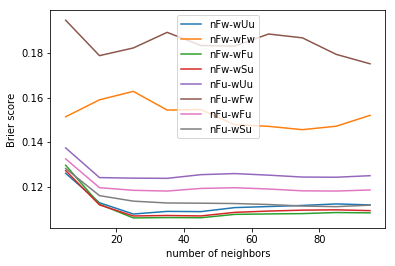

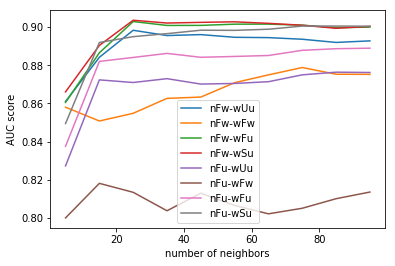

In [132]:
pd.DataFrame(brier_scores).plot()
plt.xlabel('number of neighbors')
plt.ylabel('Brier score')
plt.show()

pd.DataFrame(auc_scores).plot()
plt.xlabel('number of neighbors')
plt.ylabel('AUC score')
plt.show()

## Old experiment

#### Schemes
* nS-wU: neighbors in shap space, uniformly weighted
* nF-FU: neighbors feature space, uniformly weighted
* nS-wS: neighbors in shap space, weighted by shap space distances
* nF-wF: neighbors in feature space, weighted by feature space distances
* nS-wF: neighbors in shap space, weighted by feature space distances
* nF-wS: neighbors in feature space, weighted by shap space distances

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

class WeightedKNeighborsClassifier:
    """ Nearest Neighbors classifier with separate datasets for retrieving and weighting neighbors.
    """
    
    def __init__(self, n_neighbors, metric_n='euclidean', metric_w='euclidean', weights='distance'):
        self.nn_ = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric=metric_n)
        self.weights=weights
        if metric_w == 'euclidean':
            self.metric_w = euclidean_distances
        else:
            raise ValueError("%s not implemented; 'metric_w must be one of ['eucledian']" % self.metric_w )
        return
    
    def fit(self, X_train_n, X_train_w, y_train):
        """ fit nearest neighbor classifier
        Parameters
        ----------
        X_train_n : array [n_samples, n_features]
            data used to retrieve the neighbors
        X_train_w : array [n_samples, n_features]
            data used to weight the retrieved neighbors
        y_train : array [n_samples]
            true class
        """
        self.nn_.fit(X_train_n)
        self.X_train_w = X_train_w
        return
    
    def predict_proba(self, X_test_n, X_test_w):
        """ predict probabilities of k-NN
        Parameters
        ----------
        X_test_n : array [n_samples, n_features]
            data used to retrieve the neighbors
        X_test_w : array [n_samples, n_features]
            data used to weight the retrieved neighbors
        """
        # find neighbors
        distances_neighbors, neighbors = self.nn_.kneighbors(X_test_n)
        # compute distance weighted probabilities
        probabilities = []
        if self.weights == 'distance':
            for n, i in zip(neighbors, np.array(X_test_w)):
                # find distances in feature space
                X_neighbors = self.X_train_w.iloc[n]
                distances = np.array([0.0000000001 if i == 0 else i for i in self.metric_w(X_neighbors, [i]).ravel()])
                distances_weights = 1/distances
                true_class = y_train.iloc[n]['class'].ravel()
                # compute weighted score
                p = np.sum(distances_weights*true_class)/np.sum(distances_weights)
                probabilities.append([1-p, p])
        elif self.weights == 'uniform':
            for n in zip(neighbors):
                # find distances in feature space
                true_class = y_train.iloc[n]['class'].ravel()
                # compute weighted score
                p = np.mean(true_class)
                probabilities.append([1-p, p])
        return probabilities

def simulate_user(scheme, metric_n='euclidean', metric_w='euclidean', n_neighbors=10):
    """
    """
    # Set retrieve neighbors
    if scheme[1] == 'S':
        X_train_n = SHAP_base
        X_test_n = SHAP_alert
    elif scheme[1] == 'F':
        X_train_n = X_base
        X_test_n = X_alert
    # Set compute weights
    if scheme[4] == 'S':
        weights='distance'
        X_train_w = SHAP_base
        X_test_w = SHAP_alert
    elif scheme[4] == 'F':
        weights='distance'
        X_train_w = X_base
        X_test_w = X_alert
    elif scheme[4] == 'U':
        X_train_w = None
        X_test_w = None
        weights ='uniform'
        
    wknn = WeightedKNeighborsClassifier(n_neighbors=n_neighbors, metric_n=metric_n, metric_w=metric_w, weights=weights)
    wknn.fit(X_train_n, X_train_w, y_train)
    y_prob = [i[1] for i in wknn.predict_proba(X_test_n, X_test_w)]
    return y_prob

In [10]:
y_train = y_base
neighbors_range = range(5,len(X_base),10)
y_prob = {}
for scheme in ['nS-wF', 'nS-wS', 'nS-wU', 'nF-wF', 'nF-wS','nF-wU']:
    print(scheme)
    scheme_probs = {}
    for n_neighbors in neighbors_range:
        scheme_probs[n_neighbors] = simulate_user(scheme, n_neighbors=n_neighbors)
    y_prob[scheme] = scheme_probs

nS-wF
nS-wS
nS-wU
nF-wF
nF-wS
nF-wU


In [19]:
from sklearn.metrics import brier_score_loss, accuracy_score, roc_auc_score

y_true = y_alert['class'].ravel()
brier_scores = {}
auc_scores = {}
accuracy_scores = {}
for scheme in ['nS-wF', 'nS-wS', 'nS-wU', 'nF-wF', 'nF-wS','nF-wU']:
    scheme_brier_scores = {}
    scheme_auc_scores = {}
    scheme_accuracy_scores = {}
    for n_neighbors in range(5,300,10):
        y_score = y_prob[scheme][n_neighbors]
        y_pred = [1 if i >= 0.5 else 0 for i in y_score]
        scheme_brier_scores[n_neighbors] = brier_score_loss(y_true=y_true, y_prob=y_score)
        scheme_auc_scores[n_neighbors] = roc_auc_score(y_true=y_true, y_score=y_score)
        scheme_accuracy_scores[n_neighbors] = accuracy_score(y_true=y_true, y_pred=y_pred)
    brier_scores[scheme] = scheme_brier_scores
    auc_scores[scheme] = scheme_auc_scores
    accuracy_scores[scheme] = scheme_accuracy_scores

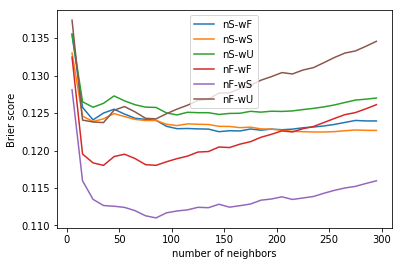

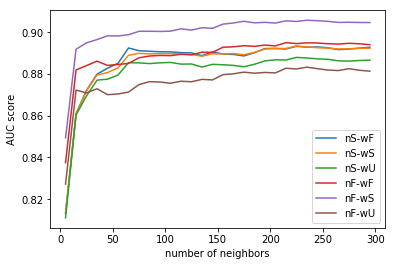

In [90]:
pd.DataFrame(brier_scores).plot()
plt.xlabel('number of neighbors')
plt.ylabel('Brier score')
plt.show()

pd.DataFrame(auc_scores).plot()
plt.xlabel('number of neighbors')
plt.ylabel('AUC score')
plt.show()

In [215]:
len(X_train)

1500